In [1]:
import io
import sys
import zipfile

import pandas as pd
import requests
import torch
import torch.nn as nn
from ogb.graphproppred import Evaluator, PygGraphPropPredDataset
from sklearn.metrics import accuracy_score, roc_auc_score
from torch_geometric.loader import DataLoader
from tqdm import tqdm

from pyg_chemprop import DMPNNEncoder, RevIndexedDataset
from pyg_chemprop_utils import FeatureScaler, NoamLR, initialize_weights, smiles2data
import torch
import torch_geometric
import torch_scatter
import ogb

from lightning.fabric import Fabric
torch.set_float32_matmul_precision("medium")

C:\Users\rhys-\AppData\Local\Temp\ipykernel_25672\3682073594.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 0
torch.manual_seed(seed);

fabric = Fabric(accelerator='cuda', precision='bf16-mixed')
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


In [3]:
import torch
import torch.nn as nn
import torch.utils.data
from torch_geometric.data import Data, Dataset
from torch_geometric.data.data import size_repr
import numpy as np
# from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.nn import global_mean_pool
from torch_scatter import scatter_sum
from tqdm import tqdm

class RevIndexedData(Data):
    def __init__(self, orig):
        super(RevIndexedData, self).__init__()
        if orig:
            for key in orig.keys():
                self[key] = orig[key]
            edge_index = self["edge_index"]
            revedge_index = torch.zeros(edge_index.shape[1]).long()
            for k, (i, j) in enumerate(zip(*edge_index)):
                edge_to_i = edge_index[1] == i
                edge_from_j = edge_index[0] == j
                revedge_index[k] = torch.where(edge_to_i & edge_from_j)[0].item()
            self["revedge_index"] = revedge_index

    def __inc__(self, key, value, *args, **kwargs):
        if key == "revedge_index":
            return self.revedge_index.max().item() + 1
        else:
            return super().__inc__(key, value)

    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return "{}({})".format(cls, ", ".join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return "{}(\n{}\n)".format(cls, ",\n".join(info))
from torch.utils.data import Dataset

class RevIndexedDataset(Dataset):
    def __init__(self, orig):
        super(RevIndexedDataset, self).__init__()
        # super().__init__()  # Fix the super() call
        self.dataset = [RevIndexedData(data) for data in tqdm(orig)]

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)



def get_dataset(df):
    data_list = []
    print("Convert to PyG Objects...", file=sys.stderr)
    for _, row in tqdm(df.iterrows(), total=len(df)):
        smi = row["smiles"]
        data = smiles2data(smi, explicit_h=True)
        data.y = torch.tensor([[row[np.arange(400,4002,2).astype(str)]]])
        data_list.append(data)
    print("Convert to RevIndexedDataset...", file=sys.stderr)
    return RevIndexedDataset(data_list)

In [4]:
path = r"C:\Users\rhys-\OneDrive\data_hnrs\spectra\nist\nist_exp_spectra_fixed.csv"
df = pd.read_csv(path)
# data_list = []
#     # print("Convert to PyG Objects...", file=sys.stderr)
# for _, row in tqdm(df.iterrows(), total=len(df)):
#     smi = row["smiles"]
#     data = smiles2data(smi, explicit_h=True)
#     data.y = torch.tensor([[row["HIV_active"]]])
#     data_list.append(data)
dataset = get_dataset(df);

Convert to PyG Objects...
  0%|          | 0/7670 [00:00<?, ?it/s]C:\Users\rhys-\AppData\Local\Temp\ipykernel_25672\2834338810.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.y = torch.tensor([[row[np.arange(400,4002,2).astype(str)]]])
  0%|          | 1/7670 [00:00<37:11,  3.44it/s]C:\Users\rhys-\AppData\Local\Temp\ipykernel_25672\2834338810.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.y = torch.tensor([[row[np.arange(400,4002,2).astype(str)]]])
C:\Users\rhys-\AppData\Local\Temp\ipykernel_25672\2834338810.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

In [5]:
# for i in range(len(dataset)):

#     dataset[i].y = dataset[i].y.squeeze()
#     print(dataset[i].y.shape)

In [6]:
# split = {
#     "train": pd.read_csv(f"{data_dir}/hiv/split/scaffold/train.csv.gz", header=None),
#     "valid": pd.read_csv(f"{data_dir}/hiv/split/scaffold/valid.csv.gz", header=None),
#     "test": pd.read_csv(f"{data_dir}/hiv/split/scaffold/test.csv.gz", header=None),
# }
# train_idx = split["train"].to_numpy().flatten()
# valid_idx = split["valid"].to_numpy().flatten()
# test_idx = split["test"].to_numpy().flatten()

# generate train, validate and test indexes for the dataset that is 7670 long
train_idx, valid_idx, test_idx = [], [], []
for idx in range(7670):
    if idx % 10 == 0:
        valid_idx.append(idx)
    elif idx % 10 == 1:
        test_idx.append(idx)
    else:
        train_idx.append(idx)

train_idx = np.array(train_idx)
valid_idx = np.array(valid_idx)
test_idx = np.array(test_idx)



In [25]:
len(train_idx), len(valid_idx), len(test_idx)

(6136, 767, 767)

In [7]:
batch_size = 50

train_raw = torch.utils.data.Subset(dataset, train_idx)
valid_raw = torch.utils.data.Subset(dataset, valid_idx)
test_raw = torch.utils.data.Subset(dataset, test_idx)

scaler = FeatureScaler(targets=["x", "edge_attr"])
train_data = scaler.fit_transform(train_raw)
valid_data = scaler.transform(valid_raw)
test_data = scaler.transform(test_raw)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 767/767 [00:00<00:00, 40365.27it/s]


In [8]:
cuda = torch.device("cuda")
dev_id = torch.cuda.current_device()
torch.cuda.get_device_name(dev_id)

'NVIDIA GeForce RTX 4070'

In [9]:
train_loader.dataset

[RevIndexedData(x=[19, 133], y=[1, 1, 1801], edge_index=[2, 38], edge_attr=[38, 14], revedge_index=[38]),
 RevIndexedData(x=[24, 133], y=[1, 1, 1801], edge_index=[2, 46], edge_attr=[46, 14], revedge_index=[46]),
 RevIndexedData(x=[18, 133], y=[1, 1, 1801], edge_index=[2, 36], edge_attr=[36, 14], revedge_index=[36]),
 RevIndexedData(x=[20, 133], y=[1, 1, 1801], edge_index=[2, 42], edge_attr=[42, 14], revedge_index=[42]),
 RevIndexedData(x=[23, 133], y=[1, 1, 1801], edge_index=[2, 46], edge_attr=[46, 14], revedge_index=[46]),
 RevIndexedData(x=[39, 133], y=[1, 1, 1801], edge_index=[2, 76], edge_attr=[76, 14], revedge_index=[76]),
 RevIndexedData(x=[17, 133], y=[1, 1, 1801], edge_index=[2, 34], edge_attr=[34, 14], revedge_index=[34]),
 RevIndexedData(x=[25, 133], y=[1, 1, 1801], edge_index=[2, 50], edge_attr=[50, 14], revedge_index=[50]),
 RevIndexedData(x=[11, 133], y=[1, 1, 1801], edge_index=[2, 20], edge_attr=[20, 14], revedge_index=[20]),
 RevIndexedData(x=[23, 133], y=[1, 1, 1801], e

In [41]:
num_epochs = 30
hidden_size = 2200
depth = 3
out_dim = 1801

rate = 0.0
head = nn.Sequential(
    nn.Dropout(p=rate, inplace=False),
    nn.Linear(hidden_size, hidden_size, bias=True),
    nn.ReLU(),
    nn.Dropout(p=rate, inplace=False),
    nn.Linear(hidden_size, out_dim, bias=True),
)
model = nn.Sequential(
    DMPNNEncoder(
        hidden_size,
        133,
        14,
        6,
    ),
    head,
)
initialize_weights(model)

model


Sequential(
  (0): DMPNNEncoder(
    (act_func): ReLU()
    (W1): Linear(in_features=147, out_features=2200, bias=False)
    (W2): Linear(in_features=2200, out_features=2200, bias=False)
    (W3): Linear(in_features=2333, out_features=2200, bias=True)
  )
  (1): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=2200, out_features=2200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=2200, out_features=1801, bias=True)
  )
)

In [43]:
model[0]

DMPNNEncoder(
  (act_func): ReLU()
  (W1): Linear(in_features=147, out_features=2200, bias=False)
  (W2): Linear(in_features=2200, out_features=2200, bias=False)
  (W3): Linear(in_features=2333, out_features=2200, bias=True)
)

In [44]:
# freeze the weights of the DMPNNEncoder and only train the head
for param in model[0].parameters():
    param.requires_grad = False



In [12]:
model, optimizer = fabric.setup(model, optimizer)

In [13]:
train_loader = fabric.setup_dataloaders(train_loader)

In [14]:
valid_loader = fabric.setup_dataloaders(valid_loader)

In [15]:
config = {
    "loss": criterion,
    "model": model,
    "optimizer": optimizer,
    "scheduler": scheduler,
}

In [16]:

# best = {'epoch': -1, 'score': float("-inf")}
# outfile = f"{data_dir}/best_snapshot.pth"

In [17]:


# create an rmse function using pytorch ops
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((torch.tensor(y_true) - torch.tensor(y_pred)) ** 2))



In [31]:
for epoch in range(100):
    criterion = nn.MSELoss()
    
    model.train()
    for batch in tqdm(train_loader, total=len(train_loader)):

        optimizer.zero_grad()
        out = model(batch)
        # print(out.shape, batch.y.shape, batch.y.squeeze().shape)
        loss = torch.sqrt(criterion(out, batch.y.squeeze().float()))
        fabric.backward(loss)
        optimizer.step()
        scheduler.step()

    print(f"Epoch: {epoch} | Loss: {loss.item():.4f}")

    if epoch % 5 == 0:

        model.eval()
        with torch.no_grad():
            y_true = []
            y_pred = []
            for batch in tqdm(valid_loader, total=len(valid_loader)):
                out = model(batch)
                y_true.append(batch.y.squeeze().cpu().numpy())
                y_pred.append(out.cpu().numpy())

            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)

            score = (rmse(y_true, y_pred))
            print(f"Epoch: {epoch}, | Valid RMSE: {score:.4f}")

100%|██████████| 123/123 [00:02<00:00, 46.88it/s]


Epoch: 0 | Loss: 0.0772


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 0, | Valid RMSE: 0.0796


100%|██████████| 123/123 [00:02<00:00, 50.37it/s]


Epoch: 1 | Loss: 0.0749


100%|██████████| 16/16 [00:00<00:00, 103.23it/s]


Epoch: 1, | Valid RMSE: 0.0716


100%|██████████| 123/123 [00:02<00:00, 50.29it/s]


Epoch: 2 | Loss: 0.0579


100%|██████████| 16/16 [00:00<00:00, 96.97it/s]


Epoch: 2, | Valid RMSE: 0.0678


100%|██████████| 123/123 [00:02<00:00, 50.35it/s]


Epoch: 3 | Loss: 0.0507


100%|██████████| 16/16 [00:00<00:00, 103.90it/s]


Epoch: 3, | Valid RMSE: 0.0650


100%|██████████| 123/123 [00:02<00:00, 51.04it/s]


Epoch: 4 | Loss: 0.0431


100%|██████████| 16/16 [00:00<00:00, 98.16it/s]


Epoch: 4, | Valid RMSE: 0.0628


100%|██████████| 123/123 [00:02<00:00, 51.66it/s]


Epoch: 5 | Loss: 0.0397


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 5, | Valid RMSE: 0.0613


100%|██████████| 123/123 [00:02<00:00, 51.23it/s]


Epoch: 6 | Loss: 0.0314


100%|██████████| 16/16 [00:00<00:00, 96.97it/s]


Epoch: 6, | Valid RMSE: 0.0604


100%|██████████| 123/123 [00:02<00:00, 49.44it/s]


Epoch: 7 | Loss: 0.0308


100%|██████████| 16/16 [00:00<00:00, 93.02it/s]


Epoch: 7, | Valid RMSE: 0.0600


100%|██████████| 123/123 [00:02<00:00, 50.02it/s]


Epoch: 8 | Loss: 0.0295


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 8, | Valid RMSE: 0.0595


100%|██████████| 123/123 [00:02<00:00, 50.10it/s]


Epoch: 9 | Loss: 0.0261


100%|██████████| 16/16 [00:00<00:00, 90.40it/s]


Epoch: 9, | Valid RMSE: 0.0596


100%|██████████| 123/123 [00:02<00:00, 50.18it/s]


Epoch: 10 | Loss: 0.0223


100%|██████████| 16/16 [00:00<00:00, 98.77it/s]


Epoch: 10, | Valid RMSE: 0.0592


100%|██████████| 123/123 [00:02<00:00, 50.02it/s]


Epoch: 11 | Loss: 0.0220


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 11, | Valid RMSE: 0.0592


100%|██████████| 123/123 [00:02<00:00, 49.72it/s]


Epoch: 12 | Loss: 0.0195


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 12, | Valid RMSE: 0.0592


100%|██████████| 123/123 [00:02<00:00, 49.92it/s]


Epoch: 13 | Loss: 0.0187


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 13, | Valid RMSE: 0.0588


100%|██████████| 123/123 [00:02<00:00, 50.04it/s]


Epoch: 14 | Loss: 0.0187


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 14, | Valid RMSE: 0.0589


100%|██████████| 123/123 [00:02<00:00, 49.78it/s]


Epoch: 15 | Loss: 0.0180


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 15, | Valid RMSE: 0.0587


100%|██████████| 123/123 [00:02<00:00, 50.27it/s]


Epoch: 16 | Loss: 0.0211


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 16, | Valid RMSE: 0.0588


100%|██████████| 123/123 [00:02<00:00, 50.27it/s]


Epoch: 17 | Loss: 0.0172


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 17, | Valid RMSE: 0.0586


100%|██████████| 123/123 [00:02<00:00, 50.66it/s]


Epoch: 18 | Loss: 0.0169


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 18, | Valid RMSE: 0.0586


100%|██████████| 123/123 [00:02<00:00, 50.29it/s]


Epoch: 19 | Loss: 0.0147


100%|██████████| 16/16 [00:00<00:00, 103.90it/s]


Epoch: 19, | Valid RMSE: 0.0585


100%|██████████| 123/123 [00:02<00:00, 50.16it/s]


Epoch: 20 | Loss: 0.0155


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 20, | Valid RMSE: 0.0586


100%|██████████| 123/123 [00:02<00:00, 50.27it/s]


Epoch: 21 | Loss: 0.0148


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 21, | Valid RMSE: 0.0585


100%|██████████| 123/123 [00:02<00:00, 50.08it/s]


Epoch: 22 | Loss: 0.0123


100%|██████████| 16/16 [00:00<00:00, 98.76it/s]


Epoch: 22, | Valid RMSE: 0.0586


100%|██████████| 123/123 [00:02<00:00, 50.60it/s]


Epoch: 23 | Loss: 0.0136


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 23, | Valid RMSE: 0.0583


100%|██████████| 123/123 [00:02<00:00, 50.18it/s]


Epoch: 24 | Loss: 0.0135


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 24, | Valid RMSE: 0.0585


100%|██████████| 123/123 [00:02<00:00, 50.47it/s]


Epoch: 25 | Loss: 0.0130


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 25, | Valid RMSE: 0.0583


100%|██████████| 123/123 [00:02<00:00, 49.80it/s]


Epoch: 26 | Loss: 0.0137


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 26, | Valid RMSE: 0.0584


100%|██████████| 123/123 [00:02<00:00, 50.16it/s]


Epoch: 27 | Loss: 0.0457


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 27, | Valid RMSE: 0.0585


100%|██████████| 123/123 [00:02<00:00, 50.10it/s]


Epoch: 28 | Loss: 0.0148


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 28, | Valid RMSE: 0.0583


100%|██████████| 123/123 [00:02<00:00, 49.94it/s]


Epoch: 29 | Loss: 0.0127


100%|██████████| 16/16 [00:00<00:00, 95.24it/s]


Epoch: 29, | Valid RMSE: 0.0585


100%|██████████| 123/123 [00:02<00:00, 49.60it/s]


Epoch: 30 | Loss: 0.0166


100%|██████████| 16/16 [00:00<00:00, 98.16it/s]


Epoch: 30, | Valid RMSE: 0.0582


100%|██████████| 123/123 [00:02<00:00, 50.41it/s]


Epoch: 31 | Loss: 0.0137


100%|██████████| 16/16 [00:00<00:00, 101.27it/s]


Epoch: 31, | Valid RMSE: 0.0582


100%|██████████| 123/123 [00:02<00:00, 50.25it/s]


Epoch: 32 | Loss: 0.0127


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 32, | Valid RMSE: 0.0580


100%|██████████| 123/123 [00:02<00:00, 50.29it/s]


Epoch: 33 | Loss: 0.0118


100%|██████████| 16/16 [00:00<00:00, 95.24it/s]


Epoch: 33, | Valid RMSE: 0.0583


100%|██████████| 123/123 [00:02<00:00, 49.72it/s]


Epoch: 34 | Loss: 0.0121


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 34, | Valid RMSE: 0.0581


100%|██████████| 123/123 [00:02<00:00, 50.29it/s]


Epoch: 35 | Loss: 0.0119


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 35, | Valid RMSE: 0.0582


100%|██████████| 123/123 [00:02<00:00, 50.10it/s]


Epoch: 36 | Loss: 0.0185


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 36, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 50.53it/s]


Epoch: 37 | Loss: 0.0116


100%|██████████| 16/16 [00:00<00:00, 91.43it/s]


Epoch: 37, | Valid RMSE: 0.0583


100%|██████████| 123/123 [00:02<00:00, 50.47it/s]


Epoch: 38 | Loss: 0.0192


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 38, | Valid RMSE: 0.0580


100%|██████████| 123/123 [00:02<00:00, 50.35it/s]


Epoch: 39 | Loss: 0.0121


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 39, | Valid RMSE: 0.0580


100%|██████████| 123/123 [00:02<00:00, 49.54it/s]


Epoch: 40 | Loss: 0.0112


100%|██████████| 16/16 [00:00<00:00, 101.27it/s]


Epoch: 40, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 50.72it/s]


Epoch: 41 | Loss: 0.0113


100%|██████████| 16/16 [00:00<00:00, 96.39it/s]


Epoch: 41, | Valid RMSE: 0.0581


100%|██████████| 123/123 [00:02<00:00, 50.31it/s]


Epoch: 42 | Loss: 0.0113


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 42, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 50.37it/s]


Epoch: 43 | Loss: 0.0098


100%|██████████| 16/16 [00:00<00:00, 96.39it/s]


Epoch: 43, | Valid RMSE: 0.0581


100%|██████████| 123/123 [00:02<00:00, 50.35it/s]


Epoch: 44 | Loss: 0.0112


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 44, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.47it/s]


Epoch: 45 | Loss: 0.0184


100%|██████████| 16/16 [00:00<00:00, 101.26it/s]


Epoch: 45, | Valid RMSE: 0.0582


100%|██████████| 123/123 [00:02<00:00, 50.22it/s]


Epoch: 46 | Loss: 0.0098


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 46, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 49.58it/s]


Epoch: 47 | Loss: 0.0108


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 47, | Valid RMSE: 0.0581


100%|██████████| 123/123 [00:02<00:00, 49.70it/s]


Epoch: 48 | Loss: 0.0104


100%|██████████| 16/16 [00:00<00:00, 96.97it/s]


Epoch: 48, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.08it/s]


Epoch: 49 | Loss: 0.0097


100%|██████████| 16/16 [00:00<00:00, 102.56it/s]


Epoch: 49, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 49.76it/s]


Epoch: 50 | Loss: 0.0105


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 50, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 49.90it/s]


Epoch: 51 | Loss: 0.0127


100%|██████████| 16/16 [00:00<00:00, 92.49it/s]


Epoch: 51, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 49.86it/s]


Epoch: 52 | Loss: 0.0099


100%|██████████| 16/16 [00:00<00:00, 98.77it/s]


Epoch: 52, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.22it/s]


Epoch: 53 | Loss: 0.0093


100%|██████████| 16/16 [00:00<00:00, 90.91it/s]


Epoch: 53, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 50.33it/s]


Epoch: 54 | Loss: 0.0104


100%|██████████| 16/16 [00:00<00:00, 100.00it/s]


Epoch: 54, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 50.06it/s]


Epoch: 55 | Loss: 0.0154


100%|██████████| 16/16 [00:00<00:00, 86.49it/s]


Epoch: 55, | Valid RMSE: 0.0578


100%|██████████| 123/123 [00:02<00:00, 49.72it/s]


Epoch: 56 | Loss: 0.0096


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 56, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 50.31it/s]


Epoch: 57 | Loss: 0.0091


100%|██████████| 16/16 [00:00<00:00, 88.40it/s]


Epoch: 57, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 50.83it/s]


Epoch: 58 | Loss: 0.0094


100%|██████████| 16/16 [00:00<00:00, 101.91it/s]


Epoch: 58, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 50.83it/s]


Epoch: 59 | Loss: 0.0093


100%|██████████| 16/16 [00:00<00:00, 87.91it/s]


Epoch: 59, | Valid RMSE: 0.0577


100%|██████████| 123/123 [00:02<00:00, 50.39it/s]


Epoch: 60 | Loss: 0.0100


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 60, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.45it/s]


Epoch: 61 | Loss: 0.0091


100%|██████████| 16/16 [00:00<00:00, 89.89it/s]


Epoch: 61, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 50.78it/s]


Epoch: 62 | Loss: 0.0141


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 62, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.55it/s]


Epoch: 63 | Loss: 0.0112


100%|██████████| 16/16 [00:00<00:00, 85.56it/s]


Epoch: 63, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 50.55it/s]


Epoch: 64 | Loss: 0.0097


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 64, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.31it/s]


Epoch: 65 | Loss: 0.0127


100%|██████████| 16/16 [00:00<00:00, 90.91it/s]


Epoch: 65, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 50.27it/s]


Epoch: 66 | Loss: 0.0096


100%|██████████| 16/16 [00:00<00:00, 96.38it/s]


Epoch: 66, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 50.43it/s]


Epoch: 67 | Loss: 0.0090


100%|██████████| 16/16 [00:00<00:00, 90.40it/s]


Epoch: 67, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 50.18it/s]


Epoch: 68 | Loss: 0.0092


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 68, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 47.69it/s]


Epoch: 69 | Loss: 0.0095


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 69, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 48.44it/s]


Epoch: 70 | Loss: 0.0092


100%|██████████| 16/16 [00:00<00:00, 85.56it/s]


Epoch: 70, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 48.44it/s]


Epoch: 71 | Loss: 0.0088


100%|██████████| 16/16 [00:00<00:00, 105.96it/s]


Epoch: 71, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 49.36it/s]


Epoch: 72 | Loss: 0.0095


100%|██████████| 16/16 [00:00<00:00, 82.05it/s]


Epoch: 72, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 49.08it/s]


Epoch: 73 | Loss: 0.0092


100%|██████████| 16/16 [00:00<00:00, 103.90it/s]


Epoch: 73, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 48.25it/s]


Epoch: 74 | Loss: 0.0086


100%|██████████| 16/16 [00:00<00:00, 84.66it/s]


Epoch: 74, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 50.16it/s]


Epoch: 75 | Loss: 0.0081


100%|██████████| 16/16 [00:00<00:00, 110.35it/s]


Epoch: 75, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 52.34it/s]


Epoch: 76 | Loss: 0.0093


100%|██████████| 16/16 [00:00<00:00, 111.11it/s]


Epoch: 76, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 52.50it/s]


Epoch: 77 | Loss: 0.0081


100%|██████████| 16/16 [00:00<00:00, 98.77it/s]


Epoch: 77, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 48.43it/s]


Epoch: 78 | Loss: 0.0084


100%|██████████| 16/16 [00:00<00:00, 104.58it/s]


Epoch: 78, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 49.02it/s]


Epoch: 79 | Loss: 0.0085


100%|██████████| 16/16 [00:00<00:00, 105.26it/s]


Epoch: 79, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 49.70it/s]


Epoch: 80 | Loss: 0.0160


100%|██████████| 16/16 [00:00<00:00, 103.23it/s]


Epoch: 80, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 49.86it/s]


Epoch: 81 | Loss: 0.0100


100%|██████████| 16/16 [00:00<00:00, 103.90it/s]


Epoch: 81, | Valid RMSE: 0.0571


100%|██████████| 123/123 [00:02<00:00, 49.74it/s]


Epoch: 82 | Loss: 0.0160


100%|██████████| 16/16 [00:00<00:00, 104.57it/s]


Epoch: 82, | Valid RMSE: 0.0574


100%|██████████| 123/123 [00:02<00:00, 49.36it/s]


Epoch: 83 | Loss: 0.0079


100%|██████████| 16/16 [00:00<00:00, 103.90it/s]


Epoch: 83, | Valid RMSE: 0.0571


100%|██████████| 123/123 [00:02<00:00, 49.80it/s]


Epoch: 84 | Loss: 0.0085


100%|██████████| 16/16 [00:00<00:00, 105.27it/s]


Epoch: 84, | Valid RMSE: 0.0576


100%|██████████| 123/123 [00:02<00:00, 49.24it/s]


Epoch: 85 | Loss: 0.0082


100%|██████████| 16/16 [00:00<00:00, 100.63it/s]


Epoch: 85, | Valid RMSE: 0.0570


100%|██████████| 123/123 [00:02<00:00, 49.66it/s]


Epoch: 86 | Loss: 0.0088


100%|██████████| 16/16 [00:00<00:00, 90.91it/s]


Epoch: 86, | Valid RMSE: 0.0575


100%|██████████| 123/123 [00:02<00:00, 46.79it/s]


Epoch: 87 | Loss: 0.0080


100%|██████████| 16/16 [00:00<00:00, 95.81it/s]


Epoch: 87, | Valid RMSE: 0.0571


100%|██████████| 123/123 [00:02<00:00, 49.18it/s]


Epoch: 88 | Loss: 0.0083


100%|██████████| 16/16 [00:00<00:00, 95.81it/s]


Epoch: 88, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 48.89it/s]


Epoch: 89 | Loss: 0.0083


100%|██████████| 16/16 [00:00<00:00, 97.56it/s]


Epoch: 89, | Valid RMSE: 0.0570


100%|██████████| 123/123 [00:02<00:00, 49.24it/s]


Epoch: 90 | Loss: 0.0152


100%|██████████| 16/16 [00:00<00:00, 94.12it/s]


Epoch: 90, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 48.98it/s]


Epoch: 91 | Loss: 0.0091


100%|██████████| 16/16 [00:00<00:00, 86.96it/s]


Epoch: 91, | Valid RMSE: 0.0571


100%|██████████| 123/123 [00:02<00:00, 49.64it/s]


Epoch: 92 | Loss: 0.0081


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 92, | Valid RMSE: 0.0572


100%|██████████| 123/123 [00:02<00:00, 50.25it/s]


Epoch: 93 | Loss: 0.0141


100%|██████████| 16/16 [00:00<00:00, 86.02it/s]


Epoch: 93, | Valid RMSE: 0.0572


100%|██████████| 123/123 [00:02<00:00, 49.32it/s]


Epoch: 94 | Loss: 0.0199


100%|██████████| 16/16 [00:00<00:00, 99.38it/s]


Epoch: 94, | Valid RMSE: 0.0572


100%|██████████| 123/123 [00:02<00:00, 48.87it/s]


Epoch: 95 | Loss: 0.0085


100%|██████████| 16/16 [00:00<00:00, 93.57it/s]


Epoch: 95, | Valid RMSE: 0.0572


100%|██████████| 123/123 [00:02<00:00, 49.80it/s]


Epoch: 96 | Loss: 0.0101


100%|██████████| 16/16 [00:00<00:00, 96.97it/s]


Epoch: 96, | Valid RMSE: 0.0573


100%|██████████| 123/123 [00:02<00:00, 49.74it/s]


Epoch: 97 | Loss: 0.0124


100%|██████████| 16/16 [00:00<00:00, 90.91it/s]


Epoch: 97, | Valid RMSE: 0.0570


100%|██████████| 123/123 [00:02<00:00, 50.16it/s]


Epoch: 98 | Loss: 0.0149


100%|██████████| 16/16 [00:00<00:00, 88.40it/s]


Epoch: 98, | Valid RMSE: 0.0571


100%|██████████| 123/123 [00:02<00:00, 49.22it/s]


Epoch: 99 | Loss: 0.0070


100%|██████████| 16/16 [00:00<00:00, 98.16it/s]

Epoch: 99, | Valid RMSE: 0.0571


In [33]:
test_loader = fabric.setup_dataloaders(test_loader)


ValueError: A dataloader should be passed only once to the `setup_dataloaders` method.

In [34]:

model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []
    for batch in tqdm(test_loader, total=len(test_loader)):
        out = model(batch)
        y_true.append(batch.y.squeeze().cpu().numpy())
        y_pred.append(out.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    score = (rmse(y_true, y_pred))
    print(f"Test RMSE: {score:.4f}")


    

100%|██████████| 16/16 [00:00<00:00, 66.95it/s]

Test RMSE: 0.0650


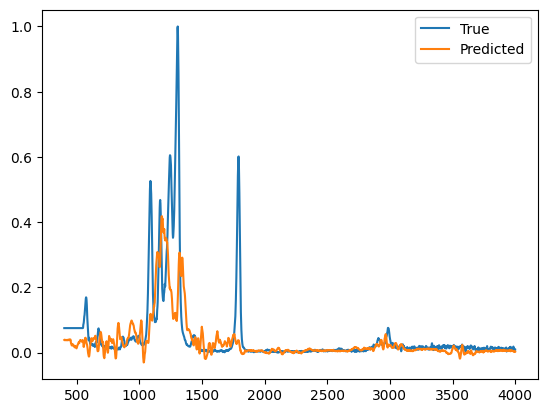

In [35]:
import matplotlib.pyplot as plt
lbls = np.arange(400,4002,2)
i = 5
plt.plot(lbls, y_true[i], label="True")
plt.plot(lbls, y_pred[i], label="Predicted")
plt.legend()
plt.show()

In [38]:
# freeze the weights of the DMPNNEncoder and train the head
for param in model[0].parameters():
    # param.requires_grad = False
    print(param)
    break




TypeError: '_FabricModule' object is not subscriptable

In [19]:
def train(config, loader, device=torch.device("cpu")):
    criterion = config["loss"]
    model = config["model"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]

    model = model.to(device)
    model.train()
    for batch in tqdm(loader, total=len(loader)):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        # print(out.shape, batch.y.shape, batch.y.squeeze().shape)
        loss = criterion(out, batch.y.squeeze().float())
        loss.backward()
        optimizer.step()
        scheduler.step()

def make_prediction(config, loader, device=torch.device("cpu")):
    model = config["model"]

    model = model.to(device)
    model.eval()
    y_pred = []
    y_true = []
    for batch in tqdm(loader, total=len(loader)):
        batch = batch.to(device)
        with torch.no_grad():
            batch_preds = torch.sigmoid(model(batch))
        y_pred.extend(batch_preds)
        y_true.extend(batch.y)
    return torch.stack(y_pred).cpu(), torch.stack(y_true).cpu()      

In [20]:
num_epochs = 100

In [21]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}", file=sys.stderr)
    train(config, train_loader, device=cuda)
    y_pred, y_true = make_prediction(config, valid_loader, device=cuda)
    # auc = roc_auc_score(y_true, y_pred)
    # if auc > best['score']:
    #     print(f"* best-auc {best['score']:.6} ==> {auc:.6}", file=sys.stderr)
    #     best['score'] = auc
    #     best['epoch'] = epoch+1
    #     torch.save(model.state_dict(), outfile)
    # acc = accuracy_score(y_true, (y_pred > 0.5).int())
    # print(f"val auc={auc:.6} acc={acc:.6}", file=sys.stderr)

Epoch 1
100%|██████████| 16/16 [00:00<00:00, 102.57it/s]
Epoch 2
100%|██████████| 16/16 [00:00<00:00, 104.57it/s]
Epoch 3
100%|██████████| 16/16 [00:00<00:00, 103.89it/s]
Epoch 4
100%|██████████| 16/16 [00:00<00:00, 105.96it/s]
Epoch 5
100%|██████████| 16/16 [00:00<00:00, 97.56it/s]
Epoch 6
100%|██████████| 16/16 [00:00<00:00, 110.34it/s]
Epoch 7
100%|██████████| 16/16 [00:00<00:00, 111.89it/s]
Epoch 8
100%|██████████| 16/16 [00:00<00:00, 106.67it/s]
Epoch 9
100%|██████████| 16/16 [00:00<00:00, 109.59it/s]
Epoch 10
100%|██████████| 16/16 [00:00<00:00, 108.11it/s]
Epoch 11
100%|██████████| 16/16 [00:00<00:00, 109.59it/s]
Epoch 12
100%|██████████| 16/16 [00:00<00:00, 110.34it/s]
Epoch 13
100%|██████████| 16/16 [00:00<00:00, 109.59it/s]
Epoch 14
100%|██████████| 16/16 [00:00<00:00, 108.84it/s]
Epoch 15
100%|██████████| 16/16 [00:00<00:00, 109.59it/s]
Epoch 16
100%|██████████| 16/16 [00:00<00:00, 109.59it/s]
Epoch 17
100%|██████████| 16/16 [00:00<00:00, 111.11it/s]
Epoch 18
100%|██████████

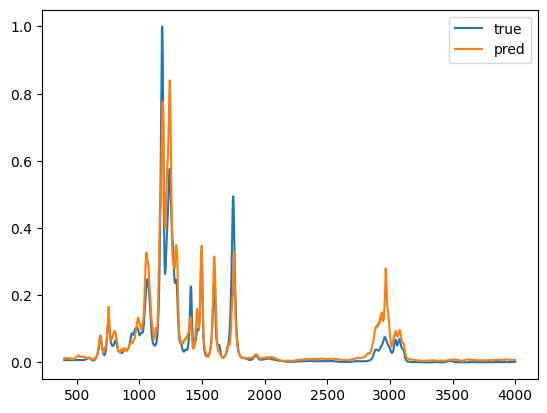

In [22]:
import matplotlib.pyplot as plt


lbls = np.arange(400,4002,2)
plt.plot(lbls, y_true[0].squeeze().numpy(), label="true")
plt.plot(lbls, y_pred[0].squeeze().numpy(), label="pred")
plt.legend()
plt.show()
